## **Import Libraries**

In [ ]:
# Baisc Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
import joblib
import pickle
import os
from pathlib import Path
import glob
from tqdm import tqdm
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

# Text processing Libraries
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from string import punctuation 
from wordcloud import WordCloud, STOPWORDS

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score,  accuracy_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
# !pip install xgboost-gpu

# Word2Vec Libraries
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

# sklearn pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config  # Display Pipeline
set_config(display='diagram')

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, concatenate, LSTM, CuDNNLSTM, Dense, BatchNormalization, Dropout
from keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##**1.Load Dataset**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/ML_CaseStudies/2_Cancer_Diagnosis/

/content/drive/MyDrive/Colab Notebooks/ML_CaseStudies/2_Cancer_Diagnosis


In [ ]:
df = pd.read_csv("data/clean_data.csv")

## **2. Train Test Split**

In [ ]:
# read the x and y from df
x, y = df[['gene','variation','clean_text']], df['class']
# train test split of x and y
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state = 33)

In [ ]:
print("shape of x_train and y_train", x_train.shape, y_train.shape)

shape of x_train and y_train (2656, 3) (2656,)


In [ ]:
x_train.head(2)

,gene,variation,clean_text
2651,BRCA1,R841Q,mutations brca1 brca2 account majority heredit...
788,ERBB4,T244R,recent efforts comprehensively characterize mu...


## **Utility Functions**

In [ ]:
def heatmp_mat(M, name, ax):
    """ This function represents confusion matrix in heatmap format """
    labels = list(range(1,10))
    # cmap =sns.light_palette("blue") #"YlGnBu"
    sns.heatmap(M, annot=True,  fmt=".3f", cmap = "YlGnBu", xticklabels=labels, yticklabels=labels, ax =ax)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Original Class')
    ax.set_title(name, fontsize=10)

def plot_confusion_matrix(test_y, predict_y):
    """ This function plots the confusion matrices given test_y, predict_y """

    C = confusion_matrix(test_y, predict_y)
    B =(C/C.sum(axis=0))
    A =(((C.T)/(C.sum(axis=1))).T)

    fig,ax = plt.subplots(nrows=3, ncols=1,figsize=(15,15))
    heatmp_mat(C, "Confusion matrix", ax = ax[0])
    heatmp_mat(B, "Precision matrix (Columm Sum=1)", ax = ax[1])
    heatmp_mat(A, "Recall matrix (Row sum=1)", ax = ax[2])
    plt.show()

def print_scores(test_y, predict_y):
    """ This function calculates and prints the scores given test_y, predict_y """

    acc_test = accuracy_score(test_y,predict_y)*100
    print("accuracy  is {0:.2f}%".format(acc_test))

    precision = precision_score(test_y,predict_y, average = 'weighted')*100
    print("precision score : {0:.2f}%".format(round(precision,2)))

    recall= recall_score(test_y,predict_y, average = 'weighted')*100
    print("Recall score : {0:.2f}%" .format(round(recall,2)))

    f1score = f1_score(test_y,predict_y, average = 'weighted')*100
    print("F1-score : {0:.2f}%".format(round(f1score,2)))

    print("Percentage of mis-classified points :", np.count_nonzero((predict_y- test_y))/test_y.shape[0])

    return

## **ML Models**

### **3.1 Logistic Regression Model**

* One hot encoding for gene and variants.
* TF-IDF vectors for text

In [ ]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

ct1 = ColumnTransformer(transformers = [('ohe_gene', OneHotEncoder(handle_unknown = 'ignore'), [0]),
                                        ('ohe_variants', OneHotEncoder(handle_unknown = 'ignore'), [1]),
                                        ('tfidf_text', TfidfVectorizer(max_features = 200), 2)
                                        ])

model = SGDClassifier(loss='log', penalty='l2', class_weight='balanced', random_state=42)

pipe = make_pipeline(ct1, model)

# perform cross validation
param_grid = {"sgdclassifier__alpha": [10 ** x for x in range(-4, 3)]}
grid_search = GridSearchCV(pipe, param_grid, scoring="neg_log_loss", cv=3, return_train_score=True, verbose=3, n_jobs=-1)

# calibration
calibrated_model = CalibratedClassifierCV(grid_search, cv=3, method="isotonic", n_jobs=-1)
calibrated_model.fit(x_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=Pipeline(steps=[('columntransformer',
                                                                         ColumnTransformer(transformers=[('ohe_gene',
                                                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                                                          [0]),
                                                                                                         ('ohe_variants',
                                                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                                                          [1]),
                                                                                                         ('tfidf_text',
                                                                                                          TfidfVectorizer(max_features=200),
                                                                                                          2)])),
                                                                        ('sgdclassifier',
                                                                         SGDClassifier(class_weight='balanced',
                                                                                       loss='log',
                                                                                       random_state=42))]),
                                              n_jobs=-1,
                                              param_grid={'sgdclassifier__alpha': [0.0001,
                                                                                   0.001,
                                                                                   0.01,
                                                                                   0.1,
                                                                                   1,
                                                                                   10,
                                                                                   100]},
                                              return_train_score=True,
                                              scoring='neg_log_loss',
                                              verbose=3),
                       method='isotonic', n_jobs=-1)

The train log loss is: 0.45554601244407567
The test log loss is: 1.0364278826640831
accuracy  is 64.66%
precision score : 63.49%
Recall score : 64.66%
F1-score : 62.15%
Percentage of mis-classified points : 0.3533834586466165


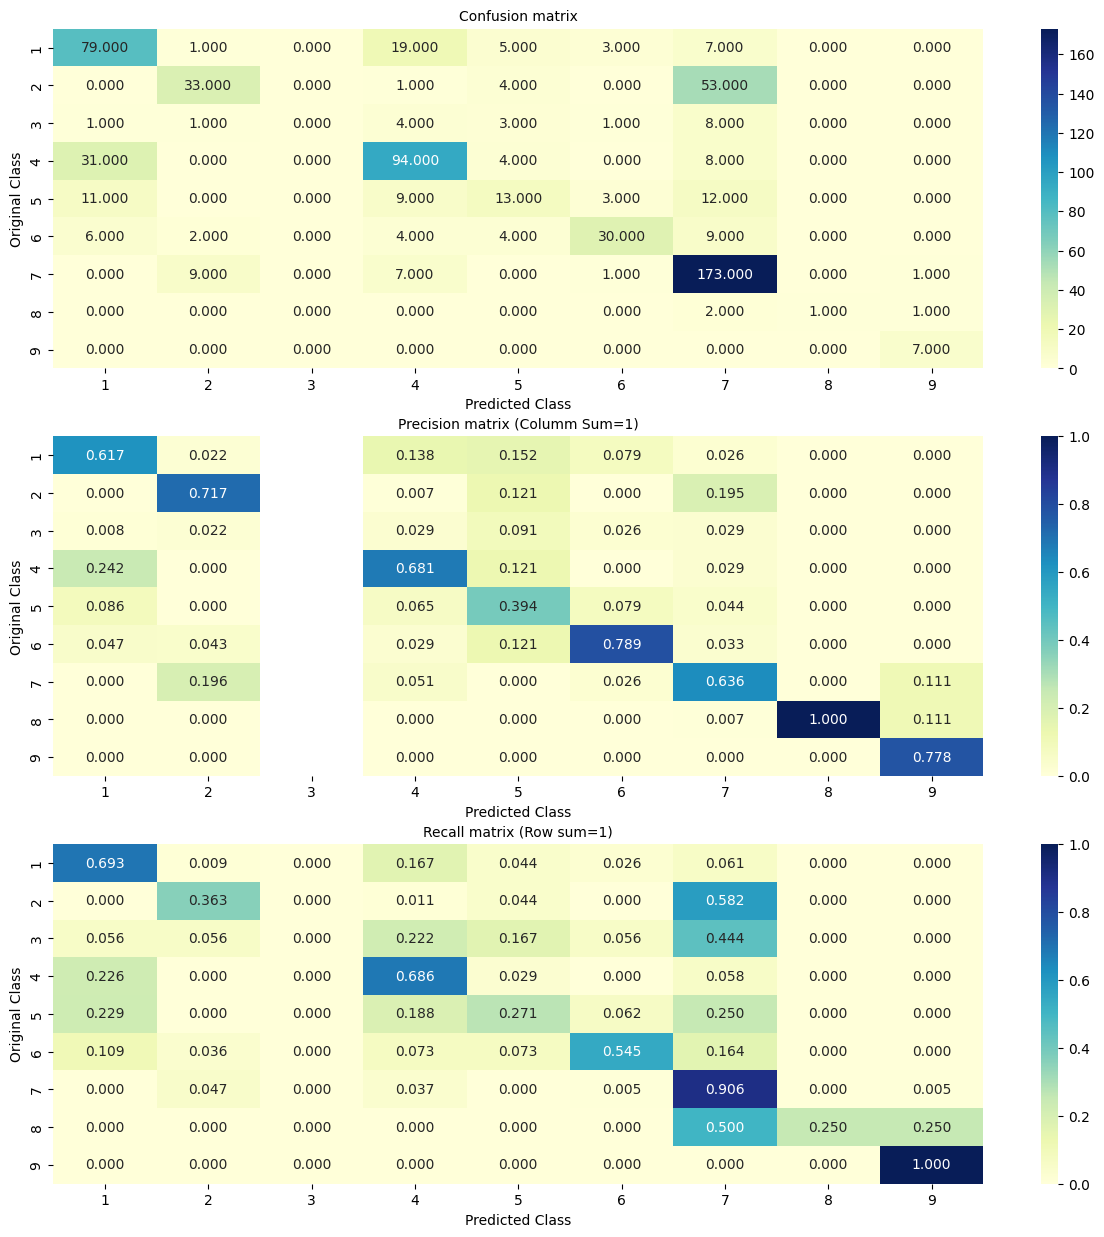

In [ ]:
# Calculate the log loss on the train data and test data
y_train_pred = calibrated_model.predict_proba(x_train)
print("The train log loss is:", log_loss(y_train, y_train_pred, labels=calibrated_model.classes_, eps=1e-15))

y_test_pred = calibrated_model.predict_proba(x_test)
print("The test log loss is:", log_loss(y_test, y_test_pred, labels=calibrated_model.classes_, eps=1e-15))

# prediction of classes
y_pred_class = np.argmax(y_test_pred, axis=1)+1
# print scores and plot confusion matrix
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)

### **3.2 SVM Model using gensim library**

* One hot encoding for gene and variants.
* Word2Vec vectors for text

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec

class Word2VecTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, embedding_file, embedding_dim):
        self.embedding_file = embedding_file
        self.embedding_dim = embedding_dim
        self.word2vec_model = None

    def fit(self, x, y=None):
        self.word2vec_model = api.load(self.embedding_file)
        return self

    def transform(self, x):
        transformed = []
        for text in x:
            vectors = []
            for word in text.split():
                if word in self.word2vec_model:
                     vectors.append(self.word2vec_model[word])
            if vectors:
                transformed.append(np.mean(vectors, axis=0))

            else:
                transformed.append(np.zeros(self.embedding_dim))

        return np.array(transformed).reshape(-1,self.embedding_dim)

In [ ]:
# Fetch the pre-trained Word2Vec model
file_name = 'glove-wiki-gigaword-300'

trf = ColumnTransformer(transformers = [('ohe_gene', OneHotEncoder(handle_unknown = 'ignore', sparse=False), [0]),
                                        ('ohe_variants', OneHotEncoder(handle_unknown = 'ignore', sparse=False), [1]),
                                        ('word2vec', Word2VecTransformer(file_name, 300), 2)
                                        ])

# Transform the data using the column transformer
x_train_transformed = trf.fit_transform(x_train)
x_test_transformed = trf.transform(x_test)

# model
model = SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced', random_state=42)

# perform cross validation
param_grid = {"alpha": [10 ** x for x in range(-4, 3)]}
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", cv=3, return_train_score=True, verbose=3, n_jobs=-1)
grid_search.fit(x_train_transformed, y_train)

# calibration
calibrated_model = CalibratedClassifierCV(grid_search.best_estimator_, cv=3, method="isotonic", n_jobs=-1)
calibrated_model.fit(x_train_transformed, y_train)

[==================================================] 100.0% 376.1/376.1MB downloaded
Fitting 3 folds for each of 7 candidates, totalling 21 fits


CalibratedClassifierCV(cv=3,
                       estimator=SGDClassifier(class_weight='balanced',
                                               random_state=42),
                       method='isotonic', n_jobs=-1)

The train log loss is: 0.35310152504806686
The test log loss is: 0.9949497028733003
accuracy  is 64.81%
precision score : 63.79%
Recall score : 64.81%
F1-score : 62.59%
Percentage of mis-classified points : 0.3518796992481203


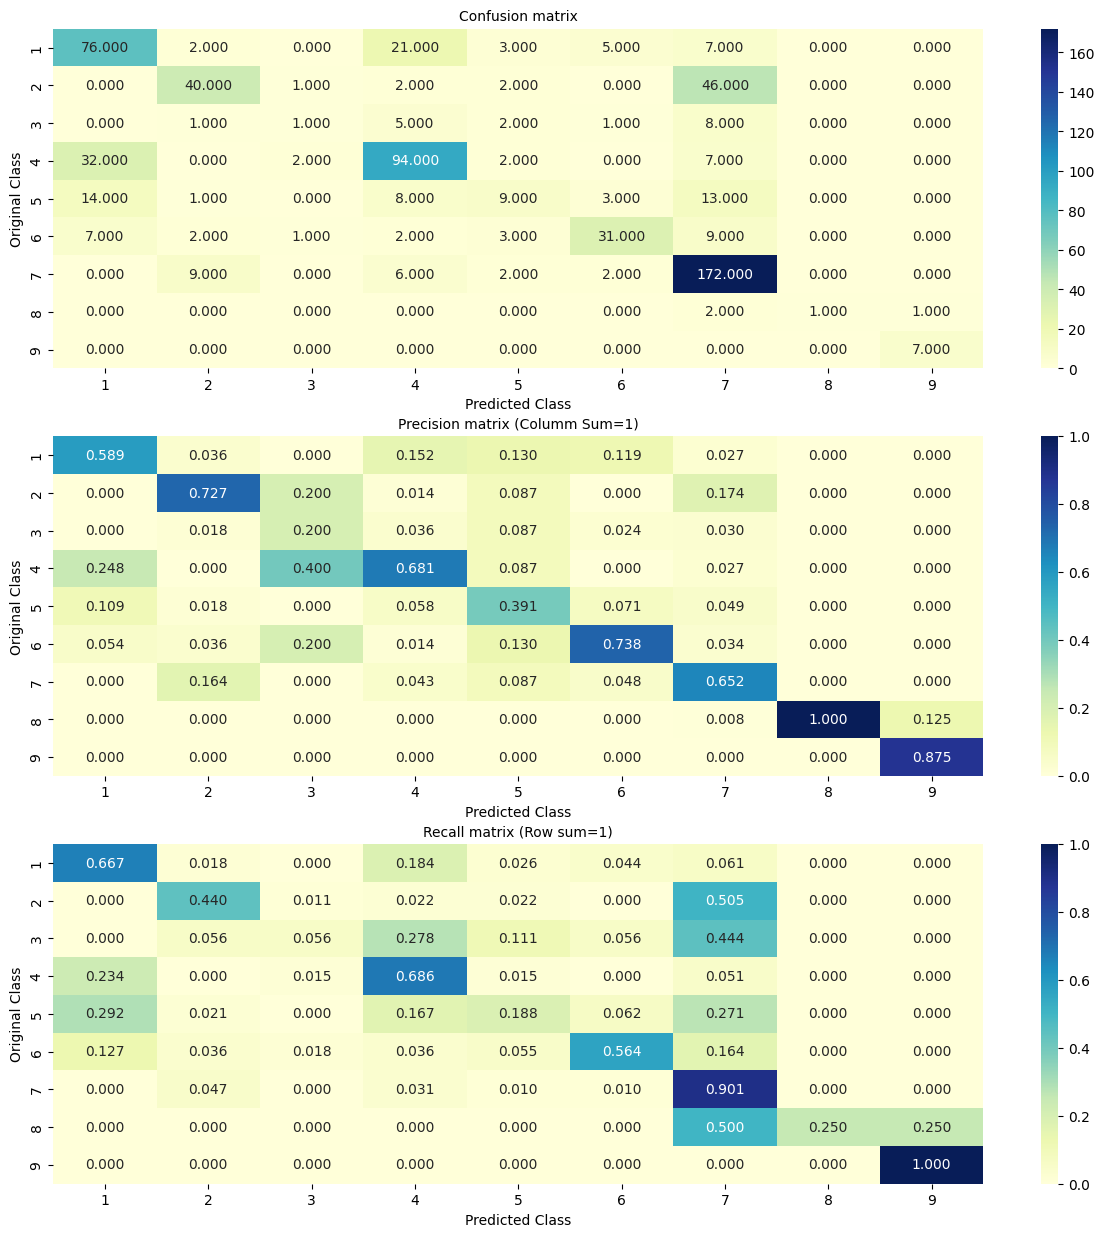

In [ ]:
# Calculate the log loss on the train data and test data
y_train_pred = calibrated_model.predict_proba(x_train_transformed)
print("The train log loss is:", log_loss(y_train, y_train_pred, labels=calibrated_model.classes_, eps=1e-15))

y_test_pred = calibrated_model.predict_proba(x_test_transformed)
print("The test log loss is:", log_loss(y_test, y_test_pred, labels=calibrated_model.classes_, eps=1e-15))

# prediction of classes
y_pred_class = np.argmax(y_test_pred, axis=1)+1
# print scores and plot confusion matrix
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)

### **3.3 Random Forest Model**

* One hot encoding for gene and variants.
* Word2Vec vectors for text

In [ ]:
# model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=42)

# perform cross validation
param_grid = {'n_estimators': [50, 100, 150, 200],
              'max_depth': [2, 4, 6, 8]
              }

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", cv=5, return_train_score=True, verbose=3, n_jobs=-1)
grid_search.fit(x_train_transformed, y_train)

# calibration
calibrated_model = CalibratedClassifierCV(grid_search.best_estimator_, cv=5, method="isotonic", n_jobs=-1)
calibrated_model.fit(x_train_transformed, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=8,
                                                        n_estimators=150,
                                                        random_state=42),
                       method='isotonic', n_jobs=-1)

The train log loss is: 0.6270981236595423
The test log loss is: 1.100074286728989
accuracy  is 59.85%
precision score : 60.26%
Recall score : 59.85%
F1-score : 58.19%
Percentage of mis-classified points : 0.40150375939849625


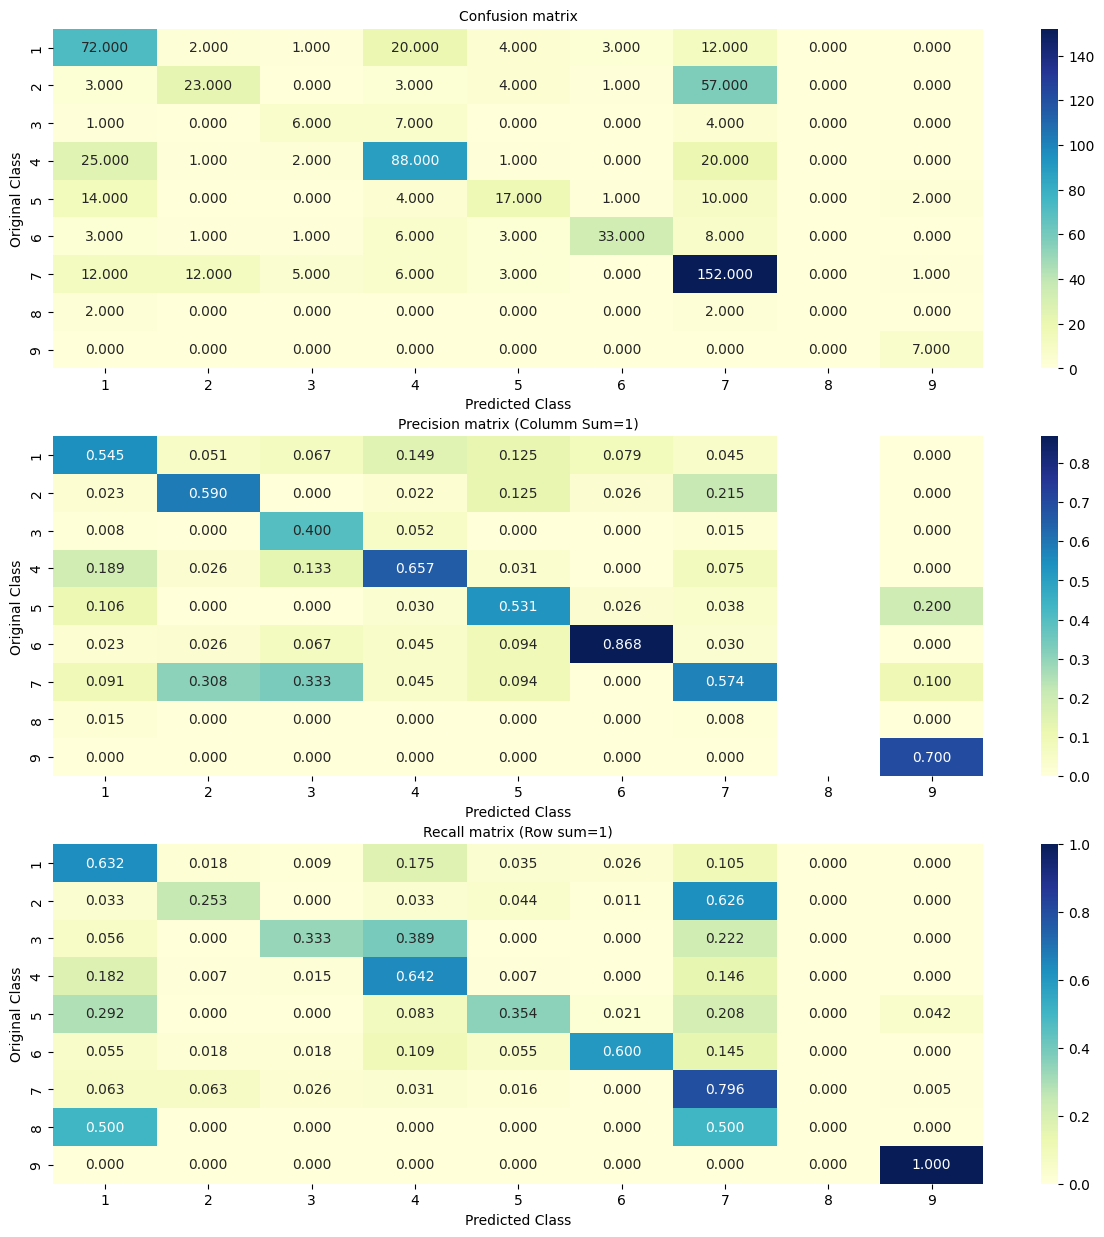

In [ ]:
# Calculate the log loss on the train data and test data
y_train_pred = calibrated_model.predict_proba(x_train_transformed)
print("The train log loss is:", log_loss(y_train, y_train_pred, labels=calibrated_model.classes_, eps=1e-15))

y_test_pred = calibrated_model.predict_proba(x_test_transformed)
print("The test log loss is:", log_loss(y_test, y_test_pred, labels=calibrated_model.classes_, eps=1e-15))

# prediction of classes
y_pred_class = np.argmax(y_test_pred, axis=1)+1
# print scores and plot confusion matrix
print_scores(y_test, y_pred_class)
plot_confusion_matrix(y_test, y_pred_class)

## **5. Results**

In [3]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model Name", "Test Log-Loss", "Accuracy","Percentage of misclassified points"]
x.add_row(["Random Model", 2.3974, 0.1098, 89.02])
x.add_row(["Logistic Regression (TFIDF)",  1.0364, 0.6466, 35.33])
x.add_row(["Linear SVM (Word2Vec)", 0.9949, 0.6481, 35.18])
x.add_row(["Random Forest (Word2Vec)", 1.1000, 0.5985, 40.15])
print(x)

+-----------------------------+---------------+----------+------------------------------------+
|          Model Name         | Test Log-Loss | Accuracy | Percentage of misclassified points |
+-----------------------------+---------------+----------+------------------------------------+
|         Random Model        |     2.3974    |  0.1098  |               89.02                |
| Logistic Regression (TFIDF) |     1.0364    |  0.6466  |               35.33                |
|    Linear SVM (Word2Vec)    |     0.9949    |  0.6481  |               35.18                |
|   Random Forest (Word2Vec)  |      1.1      |  0.5985  |               40.15                |
+-----------------------------+---------------+----------+------------------------------------+
